# Function — GO enrichment for the O43099 family (streaming SwissProt)


- Build a **foreground** set = family proteins from `O43099_verified_family.fasta`
- Build a **background** set = all **SwissProt** (reviewed UniProtKB) proteins from `uniprot_sprot.xml.gz`
- Extract **GO annotations** from UniProt XML (`dbReference type="GO"`)
- Compute **GO enrichment** using **Fisher’s exact test** (two-tailed + right-tailed)
- Apply **multiple testing correction** (BH/FDR)
- Plot a **word cloud** of enriched GO terms
- Use **GO hierarchy** from `go-basic.obo` to report enriched **branches** (ancestor terms)


In [16]:
from pathlib import Path

# Inputs 
FASTA_PATH = Path("O43099_verified_family.fasta")
OBO_PATH   = Path("go-basic.obo")

# Cache (small) files we create
CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)

BG_COUNTS_JSON = CACHE_DIR / "sprot_go_counts.json"
BG_TERMS_JSON  = CACHE_DIR / "sprot_go_terms.json"   
FAMILY_GO_JSON = CACHE_DIR / "family_go.json"        


## 1) Install / import dependencies


In [17]:
import sys
import json
import math
import gzip
import re
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
from typing import Optional

import numpy as np

from scipy.stats import fisher_exact

import matplotlib.pyplot as plt

# WordCloud download
try:
    from wordcloud import WordCloud
except ImportError:
    !{sys.executable} -m pip -q install wordcloud
    from wordcloud import WordCloud


## 2) Pipeline overview


1. Parse FASTA and extract UniProt accessions (foreground set).
2. Parse `go-basic.obo` to build a GO parent graph (for branches).
3. Build / load SwissProt background counts:
   - If cache exists: load `sprot_go_counts.json` 
   - Else: download `uniprot_sprot.xml.gz`, stream-parse it:
     - count, for each GO ID: how many SwissProt proteins have it (protein-level presence)
     - record GO names (best-effort from XML)
     - simultaneously collect GO sets for any accession in your family
     - save caches to JSON
4. Ensure we have GO annotations for all family accessions:
5. Compute enrichment with Fisher’s exact test (two-tailed + right-tailed), then BH/FDR.
6. Make a word cloud of enriched terms.
7. Summarize “enriched branches” by propagating significant terms to ancestors and ranking ancestor terms.


## 3) Foreground: parse the family FASTA

In [18]:
# UniProt accession patterns 
_UNIPROT_ACC = r"(?:[A-NR-Z][0-9]{5}|[OPQ][0-9][A-Z0-9]{3}[0-9])"

def extract_accessions_from_fasta_header(header: str) -> Optional[str]:
    """
    Extract a UniProt accession from a FASTA header.

    Works for:
      - >O43099_TIR
      - >UR50:UniRef50_P56577 ...
      - >UniRef50_P56577 ...
      - >sp|P12345|...
      - >tr|Q9XXXX|...
    """
    h = header.strip()
    if h.startswith(">"):
        h = h[1:]

    # 1) UniRef style anywhere in the header:
    m = re.search(rf"UniRef\d+_({_UNIPROT_ACC})", h)
    if m:
        return m.group(1)

    # 2) UniProt pipe style
    m = re.search(rf"\b(?:sp|tr)\|({_UNIPROT_ACC})\|", h)
    if m:
        return m.group(1)

    # 3) Accession at the start of the first token 
    first_token = h.split()[0]
    m = re.match(rf"({_UNIPROT_ACC})", first_token)
    if m:
        return m.group(1)

    # 4) Fallback: find any accession-like token in the whole header
    m = re.search(rf"\b({_UNIPROT_ACC})\b", h)
    if m:
        return m.group(1)

    return None


def parse_family_fasta_accessions(fasta_path: Path) -> list[str]:
    accessions = []
    with fasta_path.open('r', encoding='utf-8', errors='replace') as f:
        for line in f:
            if line.startswith('>'):
                acc = extract_accessions_from_fasta_header(line)
                if acc:
                    accessions.append(acc)
    # preserve order but unique
    seen=set()
    uniq=[]
    for a in accessions:
        if a not in seen:
            uniq.append(a); seen.add(a)
    return uniq


family_accessions = parse_family_fasta_accessions(FASTA_PATH)
print(f"Family size (unique accessions): {len(family_accessions)}")
print("First few:", family_accessions[:10])


Family size (unique accessions): 17
First few: ['O43099', 'P56577', 'P56578', 'Q69TY4', 'Q949U7', 'P99029', 'Q9XEX2', 'P14293', 'P73728', 'Q9BGI1']


## 4) Parse GO ontology from go-basic.obo


In [19]:
def parse_go_obo(obo_path: Path):
    """Parse a GO OBO file (go-basic.obo) into:
    - go_name: GO_ID -> term name
    - go_parents: GO_ID -> set(parent GO_IDs) (from is_a relationships)
    """
    go_name = {}
    go_parents = defaultdict(set)

    current_id = None
    current_name = None
    current_parents = set()

    def flush():
        nonlocal current_id, current_name, current_parents
        if current_id:
            if current_name:
                go_name[current_id] = current_name
            if current_parents:
                go_parents[current_id].update(current_parents)
        current_id = None
        current_name = None
        current_parents = set()

    with obo_path.open('r', encoding='utf-8', errors='replace') as f:
        for line in f:
            line=line.rstrip('\n')
            if line == '[Term]':
                flush()
                continue
            if not line or line.startswith('!'):
                continue
            if line.startswith('id: '):
                current_id = line.split('id: ')[1].strip()
            elif line.startswith('name: '):
                current_name = line.split('name: ')[1].strip()
            elif line.startswith('is_a: '):
                parent = line.split('is_a: ')[1].split(' ! ')[0].strip()
                current_parents.add(parent)
            elif line.startswith('[Typedef]'):
                # end of term section
                flush()
                break
    flush()
    return go_name, dict(go_parents)


go_name_obo, go_parents = parse_go_obo(OBO_PATH)
print(f"Parsed GO terms: {len(go_name_obo):,}")
print(f"GO terms with parents: {len(go_parents):,}")


Parsed GO terms: 48,196
GO terms with parents: 39,351


## 5) SwissProt background


In [31]:
import os, json, time, re
from collections import Counter
import requests

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

SWISSPROT_GO_COUNTS_JSON = os.path.join(CACHE_DIR, "swissprot_go_counts.json")
SWISSPROT_TOTAL_JSON = os.path.join(CACHE_DIR, "swissprot_total.json")

UNIPROT_STREAM = "https://rest.uniprot.org/uniprotkb/stream"
GO_ID_REGEX = re.compile(r"GO:\d{7}")

def parse_go_ids_from_cell(cell: str):
    if not cell:
        return set()
    return set(GO_ID_REGEX.findall(cell))

def save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f)

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def find_go_column_index(header, col):
    candidates = [
        "Gene Ontology IDs",
        "Gene ontology IDs",
        "GO IDs",
        "go_id",
        "Gene Ontology (GO)",
    ]
    for c in candidates:
        if c in col:
            return col[c]
    for k in header:
        if "ontology" in k.lower():
            return col[k]
    return None

def get_with_retries(url, params=None, stream=False, timeout=300, max_tries=8):
    s = requests.Session()
    for attempt in range(1, max_tries + 1):
        try:
            r = s.get(url, params=params, stream=stream, timeout=timeout)
            if r.status_code in (429, 500, 502, 503, 504):
                raise requests.HTTPError(f"HTTP {r.status_code}", response=r)
            r.raise_for_status()
            return r
        except Exception as e:
            if attempt == max_tries:
                raise
            wait = 2.0 * attempt
            print(f"Request failed ({type(e).__name__}: {e}). Retrying in {wait:.1f}s...")
            time.sleep(wait)

    raise RuntimeError("Unreachable")

def build_swissprot_background_go_counts_stream():
    params = {
        "query": "reviewed:true",
        "format": "tsv",
        "fields": "accession,go_id",
        # IMPORTANT: do NOT request compressed output
    }

    r = get_with_retries(UNIPROT_STREAM, params=params, stream=True, timeout=300)

    go_counts = Counter()
    total = 0

    header = None
    go_i = None
    last_log = time.time()

    for line in r.iter_lines(decode_unicode=True):
        if not line:
            continue
        line = line.strip()
        if not line:
            continue

        if header is None:
            header = line.split("\t")
            col = {name: i for i, name in enumerate(header)}
            go_i = find_go_column_index(header, col)
            if go_i is None:
                raise RuntimeError(f"Could not find GO column in API header: {header}")
            continue

        parts = line.split("\t")
        total += 1

        go_ids = parse_go_ids_from_cell(parts[go_i] if go_i < len(parts) else "")
        for go in go_ids:
            go_counts[go] += 1

        if total % 50000 == 0 or (time.time() - last_log) > 30:
            print(f"Processed reviewed proteins: {total:,}")
            last_log = time.time()

    return dict(go_counts), total

# Build or load cache
if os.path.exists(SWISSPROT_GO_COUNTS_JSON) and os.path.exists(SWISSPROT_TOTAL_JSON):
    bg_go_counts = load_json(SWISSPROT_GO_COUNTS_JSON)
    bg_total = load_json(SWISSPROT_TOTAL_JSON)["total_reviewed"]
    print("Loaded SwissProt GO background cache.")
else:
    print("Building SwissProt GO background cache via UniProt REST API (stream endpoint, uncompressed)...")
    bg_go_counts, bg_total = build_swissprot_background_go_counts_stream()
    save_json(SWISSPROT_GO_COUNTS_JSON, bg_go_counts)
    save_json(SWISSPROT_TOTAL_JSON, {"total_reviewed": bg_total})
    print("Saved SwissProt GO background cache.")

print("Background reviewed proteins (N):", f"{bg_total:,}")
print("Unique GO terms in background:", len(bg_go_counts))

Building SwissProt GO background cache via UniProt REST API (stream endpoint, uncompressed)...
Processed reviewed proteins: 46,555
Processed reviewed proteins: 50,000
Processed reviewed proteins: 100,000
Processed reviewed proteins: 150,000
Processed reviewed proteins: 200,000
Processed reviewed proteins: 250,000
Processed reviewed proteins: 300,000
Processed reviewed proteins: 350,000
Processed reviewed proteins: 400,000
Processed reviewed proteins: 450,000
Processed reviewed proteins: 500,000
Processed reviewed proteins: 550,000
Saved SwissProt GO background cache.
Background reviewed proteins (N): 574,627
Unique GO terms in background: 28620


In [33]:
import requests, re

UNIPROT_SEARCH = "https://rest.uniprot.org/uniprotkb/search"
GO_ID_REGEX = re.compile(r"GO:\d{7}")

def fetch_family_go_and_reviewed(accessions):
    query = "(" + " OR ".join([f"accession:{a}" for a in accessions]) + ")"

    params = {
        "query": query,
        "format": "tsv",
        "fields": "accession,reviewed,go_id",
        "size": 500
    }

    r = requests.get(UNIPROT_SEARCH, params=params, timeout=60)
    r.raise_for_status()

    lines = r.text.splitlines()
    header = lines[0].split("\t")
    col = {name: i for i, name in enumerate(header)}

    # UniProt sometimes uses "Entry" instead of "accession"
    acc_i = col.get("Entry", col.get("accession", 0))
    rev_i = col.get("Reviewed", col.get("reviewed", 1))

    # Find GO column robustly
    go_i = None
    for k in header:
        if "ontology" in k.lower():
            go_i = col[k]
            break
    if go_i is None:
        raise RuntimeError(f"Could not find GO column in header: {header}")

    fam_go = {}
    fam_reviewed = {}

    for line in lines[1:]:
        parts = line.split("\t")
        acc = parts[acc_i].strip()
        rev = parts[rev_i].strip().lower()
        is_reviewed = rev in ("reviewed", "true", "yes", "1")

        go_ids = set(GO_ID_REGEX.findall(parts[go_i] if go_i < len(parts) else ""))

        fam_go[acc] = go_ids
        fam_reviewed[acc] = is_reviewed

    return fam_go, fam_reviewed


fam_go, fam_reviewed = fetch_family_go_and_reviewed(family_accessions)

print("Family proteins returned:", len(fam_go))
print("Reviewed in family:", sum(fam_reviewed.values()))

Family proteins returned: 17
Reviewed in family: 17


## 6) Foreground GO annotations

In [35]:
# Restrict family to reviewed proteins (to match SwissProt background)
family_accessions_reviewed = [
    acc for acc in family_accessions
    if fam_reviewed.get(acc, False)
]

missing = [acc for acc in family_accessions_reviewed if not fam_go.get(acc)]
if missing:
    print("WARNING: Some reviewed family accessions were not found (or had no GO) in UniProt:")
    print(missing)
else:
    print("All reviewed family accessions have GO annotations.")

# Use only reviewed proteins with non-empty GO sets
family_go_nonempty = {
    acc: gos for acc, gos in fam_go.items()
    if gos and fam_reviewed.get(acc, False)
}

family_accessions_used = list(family_go_nonempty.keys())
family_n = len(family_accessions_used)

print(f"Family proteins used for enrichment (reviewed + GO): {family_n}/{len(family_accessions_reviewed)}")

All reviewed family accessions have GO annotations.
Family proteins used for enrichment (reviewed + GO): 17/17


## 7) Enrichment with Fisher’s exact test (+ BH/FDR)

We test GO terms observed in the family. For each GO term, we build a 2×2 table:

- **a** = #family proteins with the term
- **b** = family_n − a
- **c** = #SwissProt proteins with the term − a
- **d** = (bg_total − family_n) − c

Then we compute:
- two-tailed p-value
- right-tailed p-value (enrichment)
- odds ratio

Finally we apply BH/FDR correction.

In [38]:
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    """Benjamini-Hochberg FDR correction (q-values) without external dependencies."""
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(n, dtype=float)
    prev = 1.0
    for i in range(n-1, -1, -1):
        rank = i+1
        val = ranked[i] * n / rank
        prev = min(prev, val)
        q[i] = prev
    out = np.empty(n, dtype=float)
    out[order] = q
    return out


# Count GO occurrences in the family (protein-level presence)
family_term_counts = Counter()
for acc in family_accessions_used:
    for go_id in family_go_nonempty[acc]:
        family_term_counts[go_id] += 1

print(f"GO terms observed in family: {len(family_term_counts)}")

rows = []
for go_id, a in family_term_counts.items():
    a = int(a)
    b = int(family_n - a)
    bg_with = int(bg_go_counts.get(go_id, 0))
    c = int(bg_with - a)
    d = int((bg_total - family_n) - c)

    if min(a,b,c,d) < 0:
        continue

    oddsratio, p_two = fisher_exact([[a, b], [c, d]], alternative="two-sided")
    # Right-tailed enrichment: family has more than background
    _, p_right = fisher_exact([[a, b], [c, d]], alternative="greater")

    name = go_name_obo.get(go_id) or "(name unavailable)"

    rows.append((go_id, name, a, b, c, d, oddsratio, p_two, p_right))

import pandas as pd
df = pd.DataFrame(rows, columns=[
    "go_id", "go_name", "a_family_with", "b_family_without", "c_bg_with", "d_bg_without",
    "odds_ratio", "p_two_tailed", "p_right_tailed"
])

df["fdr_two_tailed"] = bh_fdr(df["p_two_tailed"].to_numpy(float))
df["fdr_right_tailed"] = bh_fdr(df["p_right_tailed"].to_numpy(float))

df_sorted = df.sort_values(["fdr_right_tailed", "p_right_tailed"]).reset_index(drop=True)
df_sorted.head(15)


GO terms observed in family: 46


,go_id,go_name,a_family_with,b_family_without,c_bg_with,d_bg_without,odds_ratio,p_two_tailed,p_right_tailed,fdr_two_tailed,fdr_right_tailed
0,GO:0008379,thioredoxin peroxidase activity,16,1,232,574378,3.961228e+04,1.502320e-53,1.502320e-53,6.910673e-52,6.910673e-52
1,GO:0045454,cell redox homeostasis,17,0,776,573834,inf,2.009929e-49,2.009929e-49,4.622836e-48,4.622836e-48
2,GO:0034599,cellular response to oxidative stress,17,0,1430,573180,inf,5.991437e-45,5.991437e-45,9.186870e-44,9.186870e-44
3,GO:0042744,hydrogen peroxide catabolic process,17,0,1690,572920,inf,1.008781e-43,1.008781e-43,1.160099e-42,1.160099e-42
4,GO:0005777,peroxisome,8,9,1171,573439,4.352891e+02,7.335104e-18,7.335104e-18,6.748295e-17,6.748295e-17
5,GO:0005739,mitochondrion,11,6,12397,562213,8.314301e+01,5.201619e-15,5.201619e-15,3.987908e-14,3.987908e-14
6,GO:0001016,RNA polymerase III transcription regulatory re...,3,14,2,574608,6.156514e+04,2.150248e-13,2.150248e-13,1.413020e-12,1.413020e-12
7,GO:0016480,negative regulation of transcription by RNA po...,3,14,35,574575,3.517806e+03,1.812855e-10,1.812855e-10,1.042392e-09,1.042392e-09
8,GO:0043027,cysteine-type endopeptidase inhibitor activity...,3,14,73,574537,1.686508e+03,1.509664e-09,1.509664e-09,7.716061e-09,7.716061e-09
9,GO:0072541,peroxynitrite reductase activity,2,15,1,574609,7.661453e+04,2.471219e-09,2.471219e-09,1.136761e-08,1.136761e-08


## 8) Pick significant terms + create a word cloud

Significant enriched GO terms at FDR <= 0.05: 39


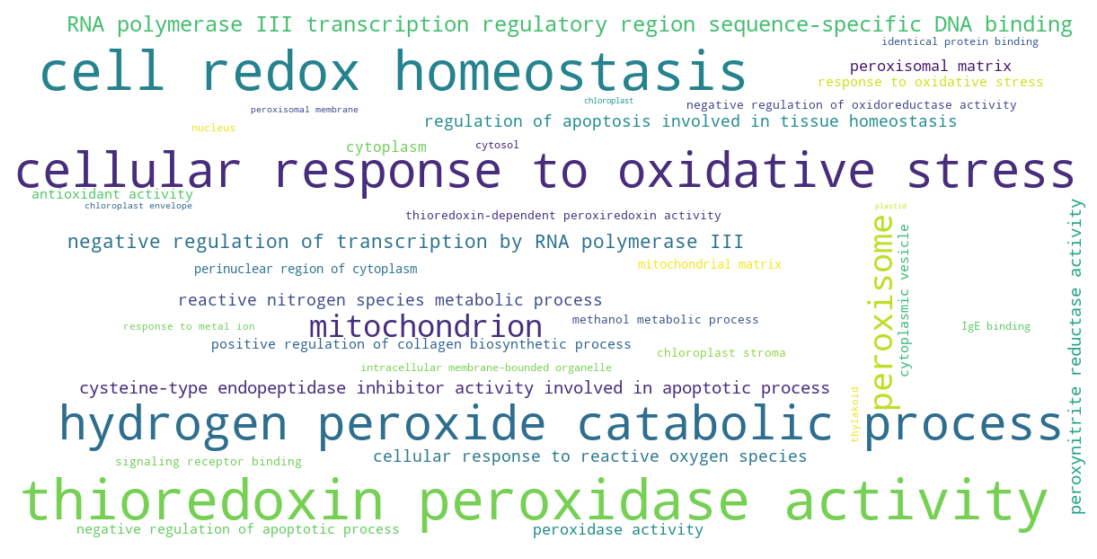

In [39]:
FDR_THRESHOLD = 0.05

sig = df_sorted[df_sorted["fdr_right_tailed"] <= FDR_THRESHOLD].copy()
print(f"Significant enriched GO terms at FDR <= {FDR_THRESHOLD}: {len(sig)}")

# Build weights for word cloud
sig["weight"] = (-np.log10(sig["fdr_right_tailed"].clip(lower=1e-300))).astype(float)

# Word frequencies mapping expects {word: weight}
wc_weights = {row.go_name: row.weight for row in sig.itertuples()}

if wc_weights:
    wc = WordCloud(width=1200, height=600, background_color="white").generate_from_frequencies(wc_weights)
    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
else:
    print("No significant terms at this threshold; try a higher threshold or check inputs.")


## 9) Enriched GO branches (hierarchy)

A simple way to summarize enriched *branches* is:
- Take significant GO terms
- For each, collect all ancestors (parents, grandparents, …) in `go-basic.obo`
- Score each ancestor by the sum of descendant weights (or count of significant descendants)
- Report top ancestors as enriched “branches”

In [40]:
def get_ancestors(go_id: str, parents_map: dict[str, set[str]]) -> set[str]:
    """Return all ancestors of a GO term (excluding itself)."""
    anc = set()
    stack = list(parents_map.get(go_id, []))
    while stack:
        p = stack.pop()
        if p in anc:
            continue
        anc.add(p)
        stack.extend(list(parents_map.get(p, [])))
    return anc

# Build ancestor scores from significant terms
ancestor_score = Counter()
ancestor_support = Counter()  # number of significant descendants

for row in sig.itertuples():
    anc = get_ancestors(row.go_id, go_parents)
    for a in anc:
        ancestor_score[a] += float(row.weight)
        ancestor_support[a] += 1

branches = []
for a, score in ancestor_score.items():
    name = go_name_obo.get(a, "(name unavailable)")
    branches.append((a, name, score, ancestor_support[a]))

branches_df = pd.DataFrame(branches, columns=["go_id", "go_name", "score", "n_sig_descendants"])
branches_df = branches_df.sort_values(["score", "n_sig_descendants"], ascending=False).reset_index(drop=True)

branches_df.head(20)


,go_id,go_name,score,n_sig_descendants
0,GO:0008150,biological_process,184.043208,13
1,GO:0009987,cellular process,102.237754,5
2,GO:0003674,molecular_function,100.341993,10
3,GO:0005575,cellular_component,71.791238,16
4,GO:0110165,cellular anatomical structure,71.791238,16
5,GO:0016209,antioxidant activity,68.429503,4
6,GO:0016684,"oxidoreductase activity, acting on peroxide as...",68.429503,4
7,GO:0016491,oxidoreductase activity,68.429503,4
8,GO:0003824,catalytic activity,68.429503,4
9,GO:0004601,peroxidase activity,61.911173,3


## 10) Export top results

This saves top enriched GO terms table and top enriched branches table

In [41]:
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

df_sorted.to_csv(OUT_DIR / "go_enrichment_all_terms.csv", index=False)
sig.to_csv(OUT_DIR / "go_enrichment_significant.csv", index=False)
branches_df.to_csv(OUT_DIR / "go_enriched_branches.csv", index=False)

print("Saved:")
print(" -", OUT_DIR / "go_enrichment_all_terms.csv")
print(" -", OUT_DIR / "go_enrichment_significant.csv")
print(" -", OUT_DIR / "go_enriched_branches.csv")


Saved:
 - outputs/go_enrichment_all_terms.csv
 - outputs/go_enrichment_significant.csv
 - outputs/go_enriched_branches.csv


In [42]:

# Select top 15 enriched GO terms
top_go = df_sorted.head(15)

latex_table = top_go[[
    "go_id", "go_name",
    "a_family_with", "c_bg_with",
    "odds_ratio", "fdr_right_tailed"
]].to_latex(index=False, float_format="%.2e")

print(latex_table)

\begin{tabular}{llrrrr}
\toprule
go_id & go_name & a_family_with & c_bg_with & odds_ratio & fdr_right_tailed \\
\midrule
GO:0008379 & thioredoxin peroxidase activity & 16 & 232 & 3.96e+04 & 6.91e-52 \\
GO:0045454 & cell redox homeostasis & 17 & 776 & inf & 4.62e-48 \\
GO:0034599 & cellular response to oxidative stress & 17 & 1430 & inf & 9.19e-44 \\
GO:0042744 & hydrogen peroxide catabolic process & 17 & 1690 & inf & 1.16e-42 \\
GO:0005777 & peroxisome & 8 & 1171 & 4.35e+02 & 6.75e-17 \\
GO:0005739 & mitochondrion & 11 & 12397 & 8.31e+01 & 3.99e-14 \\
GO:0001016 & RNA polymerase III transcription regulatory region sequence-specific DNA binding & 3 & 2 & 6.16e+04 & 1.41e-12 \\
GO:0016480 & negative regulation of transcription by RNA polymerase III & 3 & 35 & 3.52e+03 & 1.04e-09 \\
GO:0043027 & cysteine-type endopeptidase inhibitor activity involved in apoptotic process & 3 & 73 & 1.69e+03 & 7.72e-09 \\
GO:0072541 & peroxynitrite reductase activity & 2 & 1 & 7.66e+04 & 1.14e-08 \\
GO:200

In [44]:
def escape_latex(s):
    if isinstance(s, str):
        return s.replace("_", r"\_")
    return s

top_branches = branches_df.head(15)

top_branches_safe = top_branches.applymap(escape_latex)

latex_branches = top_branches_safe.to_latex(
    index=False,
    float_format="%.2f",
    escape=False
)

print(latex_branches)

\begin{tabular}{llrr}
\toprule
go_id & go_name & score & n_sig_descendants \\
\midrule
GO:0008150 & biological\_process & 184.04 & 13 \\
GO:0009987 & cellular process & 102.24 & 5 \\
GO:0003674 & molecular\_function & 100.34 & 10 \\
GO:0005575 & cellular\_component & 71.79 & 16 \\
GO:0110165 & cellular anatomical structure & 71.79 & 16 \\
GO:0016209 & antioxidant activity & 68.43 & 4 \\
GO:0016684 & oxidoreductase activity, acting on peroxide as acceptor & 68.43 & 4 \\
GO:0016491 & oxidoreductase activity & 68.43 & 4 \\
GO:0003824 & catalytic activity & 68.43 & 4 \\
GO:0004601 & peroxidase activity & 61.91 & 3 \\
GO:0050896 & response to stimulus & 56.43 & 4 \\
GO:0006950 & response to stress & 54.50 & 3 \\
GO:0051920 & peroxiredoxin activity & 53.97 & 2 \\
GO:0008152 & metabolic process & 52.09 & 3 \\
GO:0042221 & response to chemical & 52.08 & 3 \\
\bottomrule
\end{tabular}



/var/folders/zx/y690zk891278q0tkfsym931c0000gn/T/ipykernel_53899/687715899.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_branches_safe = top_branches.applymap(escape_latex)
